<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/240721_gbif_pitta_nympha_data_ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q geemap==0.33.1

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-foss4g')

In [3]:
import geemap
import os, requests
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
def get_gbif_species_data(species_name, country_code):
    """
    Retrieves observational data for a specific species using the GBIF API and returns it as a pandas DataFrame.

    Parameters:
    species_name (str): The scientific name of the species to query.
    country_code (str): The country code of the where the observation data will be queried.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the observational data.
    """
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "country": country_code,
        "hasCoordinate": "true",
        "basisOfRecord": "HUMAN_OBSERVATION",
        "limit": 10000,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raises an exception for a response error.
        data = response.json()
        occurrences = data.get("results", [])

        if occurrences:  # If data is present
            df = pd.json_normalize(occurrences)
            return df
        else:
            print("No data found for the given species and country code.")
            return pd.DataFrame()  # Returns an empty DataFrame
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()  # Returns an empty DataFrame in case of an exception

In [5]:
# Retrieve Fairy Pitta data
df = get_gbif_species_data("Pitta nympha", "KR")

# Save DataFrame to CSV and read back in.
df.to_csv("pitta_nympha_data.csv", index=False)
df = pd.read_csv("pitta_nympha_data.csv")

df.head(1)  # Display the first row of the DataFrame

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4875314160,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-07-09T01:59:58.897+00:00,2024-07-09T17:15:20.708+00:00,471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude,
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]

# Convert GeoDataFrame to GeoPackage (requires pycrs module)
%pip install -U -q pycrs
gdf.to_file("pitta_nympha_data.gpkg", driver="GPKG")
gdf = gpd.read_file("pitta_nympha_data.gpkg")

gdf.head(1)  # Display the first row of the GeoDataFrame

,species,year,month,geometry
0,Pitta nympha,2024,6,POINT (126.93219 35.41408)


In [7]:
# Yearly and monthly data distribution heatmap
def plot_heatmap(gdf, h_size=8):

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # Heatmap
    plt.figure(figsize=(h_size, h_size - 6))
    heatmap = plt.imshow(
        statistics.values, cmap="YlOrBr", origin="upper", aspect="auto"
    )

    # Display values above each pixel
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(
                j, i, statistics.values[i, j], ha="center", va="center", color="black"
            )

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig("heatmap_plot.png")
    plt.show()

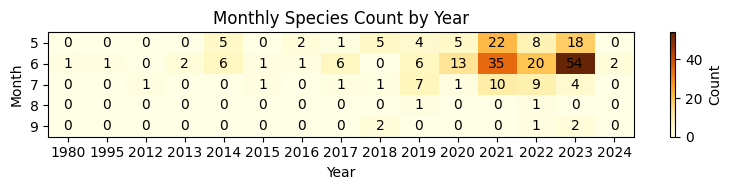

In [8]:
plot_heatmap(gdf)

### 선택한 데이터 범위와 그 이유

본 연구에서는 팔색조(Pitta nympha)의 서식지를 예측하기 위해 최근 5년간의 대한민국 지역 내 출현 데이터를 사용하였다. 구체적으로는 2019년부터 2023년까지, 5월부터 7월 사이의 데이터를 한정적으로 분석하였다. 이는 팔색조가 여름철에 주로 서식지를 이동하는 철새로서, 계절적 패턴을 반영하는 데이터가 필요하기 때문이다.

최근 5년간의 데이터를 사용하는 이유는 다음과 같다. 첫째, 최신 데이터는 현재의 환경 조건과 생태적 변화를 가장 잘 반영한다. 기후 변화와 인류 활동에 따른 환경 변화가 빠르게 진행되고 있는 상황에서 최신 데이터를 사용하는 것은 서식지 예측 모델의 정확성을 높이는 데 필수적이다. 특히, 팔색조는 환경 변화에 민감하게 반응하는 종으로, 최신 데이터를 통해 보다 정확한 예측을 할 수 있다.

또한, 팔색조는 여름철에 활발히 활동하는 철새로서 5월부터 7월 사이의 데이터는 이들의 이동 및 서식지 선택 패턴을 가장 잘 반영할 수 있다. 따라서, 이 기간 동안의 데이터를 사용함으로써 팔색조의 실제 서식지와 이동 경로를 정확하게 모델링할 수 있다.

In [9]:
# Filtering data by year and month
filtered_gdf = gdf[
    (gdf['year'].between(2019, 2023)) &
    (gdf['month'].between(5, 7))
]

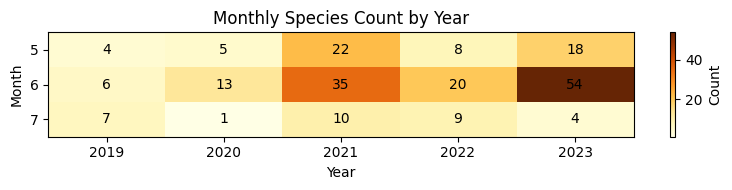

In [10]:
plot_heatmap(filtered_gdf)